### **Смена сезонов на фото**

**Цель работы:** реализовать смену сезонов на фото, смену зимних и летних пейзажей.

**Задачи:**
*   Освоить фреймворк PyTorch
*   Провести обзор статей и работ по данной теме
*   Реализовать архитектуру CycleGAN
*   Провести обучение CycleGAN на датасете зимних и летних пейзажей



### Импортируем библиотеки

In [ ]:
import os
import pdb
import pickle
import argparse
import numpy as np
import scipy
import scipy.misc
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision import transforms

import warnings
warnings.filterwarnings("ignore")

### Подключаем Google Disk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Дополнительные функции

In [ ]:
def scale(x, feature_range=(-1, 1)):
    """Необходимо преобразовать данные в соответстующий диапазон 
    в завимости от фукнции активации на выходе генератора"""
    min, max = feature_range
    x = x * (max - min) + min
    return x

[Detailed explanation of convolution and deconvolution in Pytorch (conv2d and convTranspose2d](https://www.programmersought.com/article/66075375215/)

In [ ]:
def conv2D(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Сверточный слой с батч-нормализацией"""
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [ ]:
def ConvTrans2D(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Слой деконволюция(обратная операция свертки) с батч-нормализацией """
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
                                     stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

[Saving and loading models in PyTorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended)

In [ ]:
def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='/content/drive/MyDrive/Classroom/CycleGAN/checkpoints_cyclegan'):
    if not os.path.exists(checkpoint_dir):
      os.mkdir(checkpoint_dir)
    G_XtoY_path = os.path.join(checkpoint_dir, f'G_XtoY_{iteration}.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, f'G_YtoX_{iteration}.pkl')
    D_X_path = os.path.join(checkpoint_dir, f'D_X_{iteration}.pkl')
    D_Y_path = os.path.join(checkpoint_dir, f'D_Y_{iteration}.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)

In [ ]:
def merge_images(sources, targets, batch_size=16):
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged

In [ ]:
def to_data(x):
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8)
    return x

In [ ]:
def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='/content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan'):
    if not os.path.exists(sample_dir):
      os.mkdir(sample_dir)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

In [ ]:
def myimage_loader(image_dir='/content/drive/MyDrive/Classroom/CycleGAN/mypages', image_size=64, batch_size=16):
      transform = transforms.Compose([transforms.Resize([image_size, image_size]),
                                    transforms.ToTensor()])
      image_path = os.path.join('./', image_dir)
      myimage_dataset = datasets.ImageFolder(image_path, transform)
      myimage_loader = DataLoader(dataset=myimage_dataset, batch_size=batch_size, shuffle=True)
      return myimage_loader
my_loader = myimage_loader()

### Скачиваем данные
В качестве данных рассматривается датасет состоящий из фотографий летних и зимних пейзажей ["Национального парка Йосемити".](https://en.wikipedia.org/wiki/Yosemite_National_Park)

Датасет Summer2Winter Yosemite состоит из 1540 летних фото и 1200 зимних, разделенных на тренировочное и тестовое множества

In [ ]:
!wget 'https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip'
!unzip '/content/summer2winter-yosemite.zip'

###Сделаем загрузчик изображений и посмотрим на изображения

[PyTorch DataLoader](https://pytorch.org/docs/stable/data.html) аналог ImageDataGenerator в Keras

[PyTorch Transforms](https://pytorch.org/vision/stable/transforms.html)

[Torchvision Datasets](https://pytorch.org/vision/stable/datasets.html)

[Torchvision Utils](https://pytorch.org/vision/stable/utils.html)

In [ ]:
def dataset_loader(data_path, season, img_size=(64, 64), batch_size=16):
  """
  Функция разбивает датасет, изменяет размер изображения и переводит изображение в тензор.
  """
  transform = transforms.Compose([transforms.Resize(img_size), 
                                  transforms.ToTensor()
                                  ])
  train_path, test_path = os.path.join(data_path, season), os.path.join(data_path, f'test_{season}')
  print(train_path, test_path)

  train_data, test_data = datasets.ImageFolder(train_path, transform), datasets.ImageFolder(test_path, transform)
  train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

  return train_loader, test_loader

In [ ]:
X_loader, X_test_loader = dataset_loader(data_path='./summer2winter_yosemite', season='summer')
Y_loader, Y_test_loader = dataset_loader(data_path='./summer2winter_yosemite', season='winter')


./summer2winter_yosemite/summer ./summer2winter_yosemite/test_summer
./summer2winter_yosemite/winter ./summer2winter_yosemite/test_winter


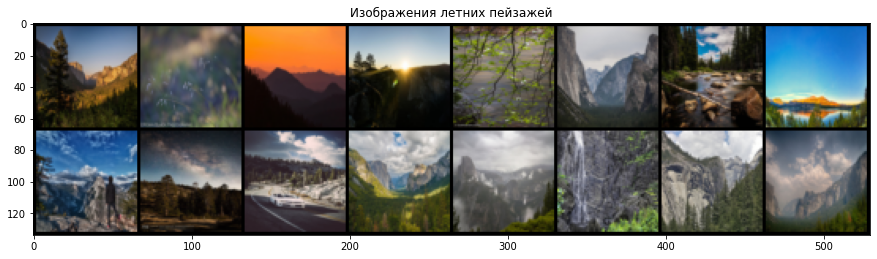

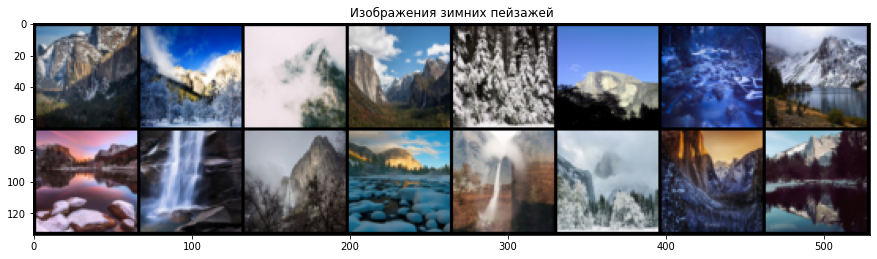

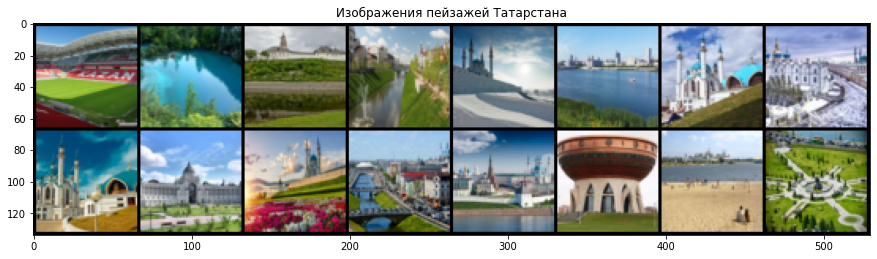

In [ ]:
iterator = iter(X_loader)
img, _ = iterator.next()
fig = plt.figure(figsize = (15, 10))
tens = torchvision.utils.make_grid(img)
img_np = tens.numpy()
plt.title('Изображения летних пейзажей')
plt.imshow(np.transpose(img_np, (1, 2, 0)));

iterator = iter(Y_loader)
img, _ = iterator.next()
fig = plt.figure(figsize = (15, 10))
tens = torchvision.utils.make_grid(img)
img_np = tens.numpy()
plt.title('Изображения зимних пейзажей')
plt.imshow(np.transpose(img_np, (1, 2, 0)));

iterator = iter(my_loader)
img, _ = iterator.next()
fig = plt.figure(figsize = (15, 10))
tens = torchvision.utils.make_grid(img)
img_np = tens.numpy()
plt.title('Изображения пейзажей Татарстана')
plt.imshow(np.transpose(img_np, (1, 2, 0)));

## Определим нашу модель

![](https://raw.githubusercontent.com/yunjey/mnist-svhn-transfer/master/gif/cyclegan.png)

[PyTorch Layers](https://pytorch.org/docs/stable/nn.html)

### Residual Block

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, conv_dim):
    super(ResidualBlock, self).__init__()
    self.layer_1 = conv2D(conv_dim, conv_dim, 3, 1, 1, batch_norm=True)
    self.layer_2 = conv2D(conv_dim, conv_dim, 3, 1, 1, batch_norm=True)

  def forward(self, x):
    out_1 = F.relu(self.layer_1(x))
    out_2 = x + self.layer_2(out_1)
    return out_2

### Generator

Архитектура Генератора
![](https://raw.githubusercontent.com/vjrahil/CycleGAN-in-Pytorch/cbe44b5097cfd876f299e31abfe98d8d578760cb/notebook_images/cyclegan_generator_ex.png)

In [ ]:
class Generator(nn.Module):

    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(Generator, self).__init__()
        self.layer_1 = conv2D(3, conv_dim, 4)
        self.layer_2 = conv2D(conv_dim, conv_dim * 2, 4)
        self.layer_3 = conv2D(conv_dim * 2, conv_dim * 4, 4)
        layers = []
        for n in range(n_res_blocks):
            layers.append(ResidualBlock(conv_dim * 4))
        self.res_blocks = nn.Sequential(*layers)
        self.layer_4 = ConvTrans2D(conv_dim * 4, conv_dim * 2, 4)
        self.layer_5 = ConvTrans2D(conv_dim * 2 , conv_dim, 4)
        self.layer_6 = ConvTrans2D(conv_dim, 3, 4, batch_norm = False)


    def forward(self, x):
        out = F.relu(self.layer_1(x))
        out = F.relu(self.layer_2(out))
        out = F.relu(self.layer_3(out))
        out = self.res_blocks(out)
        out = F.relu(self.layer_4(out))
        out = F.relu(self.layer_5(out))
        out = F.tanh(self.layer_6(out))
        return out

### Discriminator

Архитектура Дискриминатора
![](https://raw.githubusercontent.com/vjrahil/CycleGAN-in-Pytorch/cbe44b5097cfd876f299e31abfe98d8d578760cb/notebook_images/discriminator_layers.png)


In [ ]:
class Discriminator(nn.Module):
  
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        self.layer_1 = conv2D(3, conv_dim, 4, batch_norm = False)
        self.layer_2 = conv2D(conv_dim, conv_dim * 2, 4)
        self.layer_3 = conv2D(conv_dim * 2, conv_dim * 4, 4)
        self.layer_4 = conv2D(conv_dim * 4, conv_dim * 8, 4)
        self.layer_5 = conv2D(conv_dim * 8, 1, 4, 1, batch_norm = False)
        

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = F.relu(self.layer_4(x))
        x = self.layer_5(x)
        return x


###Инициализируем веса

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Собираем модель

In [ ]:
def create_model(g_conv_dim=32, d_conv_dim=32, n_res_blocks=3):
    
    G_XtoY = Generator(g_conv_dim, n_res_blocks)
    G_YtoX = Generator(g_conv_dim, n_res_blocks)

    D_X = Discriminator(d_conv_dim)
    D_Y = Discriminator(d_conv_dim)
    
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_XtoY.apply(weights_init)
        G_YtoX.to(device)
        G_YtoX.apply(weights_init)
        D_X.to(device)
        D_X.apply(weights_init)
        D_Y.to(device)
        D_Y.apply(weights_init)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [ ]:
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


In [ ]:
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
Generator(
  (layer_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (layer_1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
 

### Определяем функции потерь

In [ ]:
def real_mse_loss(D_out):
    return torch.mean((D_out - 1)**2)

def fake_mse_loss(D_out):
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return loss*lambda_weight

### Определяем функции оптимизации и гиперпараметры

In [ ]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())

g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [ ]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    losses = []
    test_iter_X, test_iter_Y = iter(test_dataloader_X), iter(test_dataloader_Y)
    fixed_X, fixed_Y = test_iter_X.next()[0], test_iter_Y.next()[0]
    fixed_X, fixed_Y = scale(fixed_X), scale(fixed_Y)


    """myimages"""
    my_iter_X = iter(my_loader)
    my_fixed_X = my_iter_X.next()[0]
    my_fixed_X = scale(my_fixed_X)

    iter_X, iter_Y = iter(dataloader_X), iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):
        if epoch % batches_per_epoch == 0:
            iter_X, iter_Y = iter(dataloader_X), iter(dataloader_Y)
        images_X, _ = iter_X.next()
        images_Y, _ = iter_Y.next()
        images_X, images_Y = scale(images_X), scale(images_Y)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X, images_Y = images_X.to(device), images_Y.to(device)
        
        d_x_optimizer.zero_grad()
        real_D_loss = real_mse_loss(D_X(images_X))
        fake_D_loss = fake_mse_loss(D_X(G_YtoX(images_Y)))
        d_x_loss = real_D_loss + fake_D_loss
        d_x_loss.backward()
        d_x_optimizer.step()
        
        d_y_optimizer.zero_grad()
        real_D_y_loss = real_mse_loss(D_Y(images_Y))
        fake_D_y_loss = fake_mse_loss(D_Y(G_XtoY(images_X)))
        d_y_loss = real_D_y_loss + fake_D_y_loss
        d_y_loss.backward()
        d_y_optimizer.step()

        g_optimizer.zero_grad()
        out_1 = G_YtoX(images_Y)
        loss_1 = real_mse_loss(D_X(out_1))
        out_2 = G_XtoY(out_1)
        loss_2 = cycle_consistency_loss(real_im = images_Y, reconstructed_im = out_2, lambda_weight=10)
        out_3 = G_XtoY(images_X)
        loss_3 = real_mse_loss(D_Y(out_3))
        out_4 = G_YtoX(out_3)
        loss_4 =  cycle_consistency_loss(real_im = images_X, reconstructed_im = out_4, lambda_weight=10)

        g_total_loss = loss_1 + loss_2 + loss_3 + loss_4
        g_total_loss.backward()
        g_optimizer.step()
        
        if epoch % print_every == 0:
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=1000
        if epoch % sample_every == 0:
            G_YtoX.eval()
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            save_samples(epoch, my_fixed_X, my_fixed_X, G_YtoX, G_XtoY, sample_dir='/content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan')
            G_YtoX.train()
            G_XtoY.train()

        checkpoint_every=1000
        # Save the model parameters
        if epoch % checkpoint_every == 0:
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses

In [ ]:
from datetime import datetime
start_time = datetime.now()
n_epochs = 10000

losses = training_loop(X_loader, Y_loader, X_test_loader, Y_test_loader, n_epochs=n_epochs)
print('Time:', datetime.now() - start_time)

Epoch [   10/10000] | d_X_loss: 0.7429 | d_Y_loss: 0.8805 | g_total_loss: 11.4022
Epoch [   20/10000] | d_X_loss: 0.4522 | d_Y_loss: 0.6309 | g_total_loss: 12.1492
Epoch [   30/10000] | d_X_loss: 0.8195 | d_Y_loss: 0.4183 | g_total_loss: 10.5218
Epoch [   40/10000] | d_X_loss: 0.3784 | d_Y_loss: 0.5045 | g_total_loss: 12.2650
Epoch [   50/10000] | d_X_loss: 0.4765 | d_Y_loss: 0.7261 | g_total_loss: 9.7391
Epoch [   60/10000] | d_X_loss: 0.4399 | d_Y_loss: 0.7981 | g_total_loss: 10.7732
Epoch [   70/10000] | d_X_loss: 0.5414 | d_Y_loss: 0.5992 | g_total_loss: 8.3323
Epoch [   80/10000] | d_X_loss: 0.6175 | d_Y_loss: 0.6196 | g_total_loss: 7.0739
Epoch [   90/10000] | d_X_loss: 0.3845 | d_Y_loss: 0.3315 | g_total_loss: 7.9268
Epoch [  100/10000] | d_X_loss: 0.6103 | d_Y_loss: 0.5192 | g_total_loss: 7.1835
Epoch [  110/10000] | d_X_loss: 0.4306 | d_Y_loss: 0.4493 | g_total_loss: 6.7155
Epoch [  120/10000] | d_X_loss: 0.4590 | d_Y_loss: 0.3997 | g_total_loss: 6.7121
Epoch [  130/10000] | d

Epoch [ 1000/10000] | d_X_loss: 0.3843 | d_Y_loss: 0.4877 | g_total_loss: 4.1024
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-001000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-001000-Y-X.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/10000] | d_X_loss: 0.3497 | d_Y_loss: 0.4024 | g_total_loss: 3.9555
Epoch [ 1020/10000] | d_X_loss: 0.4196 | d_Y_loss: 0.4277 | g_total_loss: 3.9224
Epoch [ 1030/10000] | d_X_loss: 0.4215 | d_Y_loss: 0.3954 | g_total_loss: 4.2791
Epoch [ 1040/10000] | d_X_loss: 0.3435 | d_Y_loss: 0.4207 | g_total_loss: 5.1768
Epoch [ 1050/10000] | d_X_loss: 0.3970 | d_Y_loss: 0.3331 | g_total_loss: 3.8198
Epoch [ 1060/10000] | d_X_loss: 0.4307 | d_Y_loss: 0.3927 | g_total_loss: 4.0292
Epoch [ 1070/10000] | d_X_loss: 0.3227 | d_Y_loss: 0.3486 | g_total_loss: 4.187

Epoch [ 2000/10000] | d_X_loss: 0.2165 | d_Y_loss: 0.1930 | g_total_loss: 4.2774
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-002000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-002000-Y-X.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/10000] | d_X_loss: 0.1986 | d_Y_loss: 0.1549 | g_total_loss: 4.5813
Epoch [ 2020/10000] | d_X_loss: 0.2765 | d_Y_loss: 0.2298 | g_total_loss: 4.0860
Epoch [ 2030/10000] | d_X_loss: 0.3864 | d_Y_loss: 0.1840 | g_total_loss: 4.5062
Epoch [ 2040/10000] | d_X_loss: 0.2025 | d_Y_loss: 0.1748 | g_total_loss: 4.7939
Epoch [ 2050/10000] | d_X_loss: 0.3839 | d_Y_loss: 0.3112 | g_total_loss: 4.4373
Epoch [ 2060/10000] | d_X_loss: 0.2838 | d_Y_loss: 0.1770 | g_total_loss: 4.7204
Epoch [ 2070/10000] | d_X_loss: 0.3255 | d_Y_loss: 0.1827 | g_total_loss: 4.593

Epoch [ 3000/10000] | d_X_loss: 0.1465 | d_Y_loss: 0.2012 | g_total_loss: 5.0165
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-003000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-003000-Y-X.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/10000] | d_X_loss: 0.3121 | d_Y_loss: 0.1196 | g_total_loss: 4.1158
Epoch [ 3020/10000] | d_X_loss: 0.1919 | d_Y_loss: 0.1646 | g_total_loss: 4.5632
Epoch [ 3030/10000] | d_X_loss: 0.1656 | d_Y_loss: 0.1524 | g_total_loss: 4.0702
Epoch [ 3040/10000] | d_X_loss: 0.1805 | d_Y_loss: 0.1234 | g_total_loss: 4.6082
Epoch [ 3050/10000] | d_X_loss: 0.2617 | d_Y_loss: 0.1427 | g_total_loss: 5.7453
Epoch [ 3060/10000] | d_X_loss: 0.1270 | d_Y_loss: 0.1267 | g_total_loss: 4.6131
Epoch [ 3070/10000] | d_X_loss: 0.0968 | d_Y_loss: 0.1588 | g_total_loss: 4.349

Epoch [ 4000/10000] | d_X_loss: 0.1697 | d_Y_loss: 0.1006 | g_total_loss: 4.7582
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-004000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-004000-Y-X.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004000-Y-X.png
Epoch [ 4010/10000] | d_X_loss: 0.1542 | d_Y_loss: 0.1461 | g_total_loss: 4.1687
Epoch [ 4020/10000] | d_X_loss: 0.1386 | d_Y_loss: 0.0949 | g_total_loss: 4.3500
Epoch [ 4030/10000] | d_X_loss: 0.1741 | d_Y_loss: 0.1156 | g_total_loss: 4.3230
Epoch [ 4040/10000] | d_X_loss: 0.1368 | d_Y_loss: 0.1520 | g_total_loss: 5.1769
Epoch [ 4050/10000] | d_X_loss: 0.2098 | d_Y_loss: 0.1496 | g_total_loss: 4.0790
Epoch [ 4060/10000] | d_X_loss: 0.1862 | d_Y_loss: 0.0970 | g_total_loss: 4.4761
Epoch [ 4070/10000] | d_X_loss: 0.1224 | d_Y_loss: 0.1593 | g_total_loss: 5.180

Epoch [ 5000/10000] | d_X_loss: 0.1063 | d_Y_loss: 0.1139 | g_total_loss: 4.8396
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-005000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-005000-Y-X.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-005000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-005000-Y-X.png
Epoch [ 5010/10000] | d_X_loss: 0.1121 | d_Y_loss: 0.0991 | g_total_loss: 5.4124
Epoch [ 5020/10000] | d_X_loss: 0.1594 | d_Y_loss: 0.0905 | g_total_loss: 4.5902
Epoch [ 5030/10000] | d_X_loss: 0.0956 | d_Y_loss: 0.0880 | g_total_loss: 4.7098
Epoch [ 5040/10000] | d_X_loss: 0.1447 | d_Y_loss: 0.0743 | g_total_loss: 4.7342
Epoch [ 5050/10000] | d_X_loss: 0.1255 | d_Y_loss: 0.2210 | g_total_loss: 4.1066
Epoch [ 5060/10000] | d_X_loss: 0.1344 | d_Y_loss: 0.0733 | g_total_loss: 4.6236
Epoch [ 5070/10000] | d_X_loss: 0.1829 | d_Y_loss: 0.1113 | g_total_loss: 4.395

Epoch [ 6000/10000] | d_X_loss: 0.0804 | d_Y_loss: 0.1147 | g_total_loss: 4.3859
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-006000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-006000-Y-X.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-006000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-006000-Y-X.png
Epoch [ 6010/10000] | d_X_loss: 0.1291 | d_Y_loss: 0.0745 | g_total_loss: 4.5016
Epoch [ 6020/10000] | d_X_loss: 0.1326 | d_Y_loss: 0.2120 | g_total_loss: 3.7084
Epoch [ 6030/10000] | d_X_loss: 0.0996 | d_Y_loss: 0.0739 | g_total_loss: 4.2348
Epoch [ 6040/10000] | d_X_loss: 0.3149 | d_Y_loss: 0.2807 | g_total_loss: 3.4152
Epoch [ 6050/10000] | d_X_loss: 0.1140 | d_Y_loss: 0.0985 | g_total_loss: 4.3662
Epoch [ 6060/10000] | d_X_loss: 0.1097 | d_Y_loss: 0.1388 | g_total_loss: 4.5951
Epoch [ 6070/10000] | d_X_loss: 0.1436 | d_Y_loss: 0.0536 | g_total_loss: 4.537

Epoch [ 7000/10000] | d_X_loss: 0.2288 | d_Y_loss: 0.0867 | g_total_loss: 4.3383
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-007000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-007000-Y-X.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-007000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-007000-Y-X.png
Epoch [ 7010/10000] | d_X_loss: 0.0999 | d_Y_loss: 0.0684 | g_total_loss: 4.2025
Epoch [ 7020/10000] | d_X_loss: 0.1217 | d_Y_loss: 0.0612 | g_total_loss: 4.3461
Epoch [ 7030/10000] | d_X_loss: 0.1413 | d_Y_loss: 0.0868 | g_total_loss: 4.3972
Epoch [ 7040/10000] | d_X_loss: 0.0946 | d_Y_loss: 0.0815 | g_total_loss: 4.6597
Epoch [ 7050/10000] | d_X_loss: 0.0810 | d_Y_loss: 0.0859 | g_total_loss: 5.2847
Epoch [ 7060/10000] | d_X_loss: 0.1463 | d_Y_loss: 0.0895 | g_total_loss: 4.3671
Epoch [ 7070/10000] | d_X_loss: 0.1011 | d_Y_loss: 0.1176 | g_total_loss: 4.590

Epoch [ 8000/10000] | d_X_loss: 0.0833 | d_Y_loss: 0.1172 | g_total_loss: 4.1622
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-008000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-008000-Y-X.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-008000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-008000-Y-X.png
Epoch [ 8010/10000] | d_X_loss: 0.1220 | d_Y_loss: 0.0809 | g_total_loss: 4.1779
Epoch [ 8020/10000] | d_X_loss: 0.0981 | d_Y_loss: 0.0727 | g_total_loss: 4.2415
Epoch [ 8030/10000] | d_X_loss: 0.1133 | d_Y_loss: 0.1176 | g_total_loss: 4.4158
Epoch [ 8040/10000] | d_X_loss: 0.0838 | d_Y_loss: 0.0763 | g_total_loss: 4.6558
Epoch [ 8050/10000] | d_X_loss: 0.0776 | d_Y_loss: 0.1023 | g_total_loss: 4.1555
Epoch [ 8060/10000] | d_X_loss: 0.0962 | d_Y_loss: 0.1217 | g_total_loss: 4.4136
Epoch [ 8070/10000] | d_X_loss: 0.1039 | d_Y_loss: 0.0907 | g_total_loss: 4.184

Epoch [ 9000/10000] | d_X_loss: 0.0898 | d_Y_loss: 0.0910 | g_total_loss: 4.5947
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-009000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-009000-Y-X.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-009000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-009000-Y-X.png
Epoch [ 9010/10000] | d_X_loss: 0.1360 | d_Y_loss: 0.0457 | g_total_loss: 4.6414
Epoch [ 9020/10000] | d_X_loss: 0.0813 | d_Y_loss: 0.0658 | g_total_loss: 4.3469
Epoch [ 9030/10000] | d_X_loss: 0.2417 | d_Y_loss: 0.1336 | g_total_loss: 4.4638
Epoch [ 9040/10000] | d_X_loss: 0.0859 | d_Y_loss: 0.0993 | g_total_loss: 4.4521
Epoch [ 9050/10000] | d_X_loss: 0.1033 | d_Y_loss: 0.1619 | g_total_loss: 4.0246
Epoch [ 9060/10000] | d_X_loss: 0.0759 | d_Y_loss: 0.0944 | g_total_loss: 4.5440
Epoch [ 9070/10000] | d_X_loss: 0.1078 | d_Y_loss: 0.1361 | g_total_loss: 4.414

Epoch [10000/10000] | d_X_loss: 0.1164 | d_Y_loss: 0.1118 | g_total_loss: 4.8097
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-010000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan/sample-010000-Y-X.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-010000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-010000-Y-X.png
Time: 0:16:31.271945


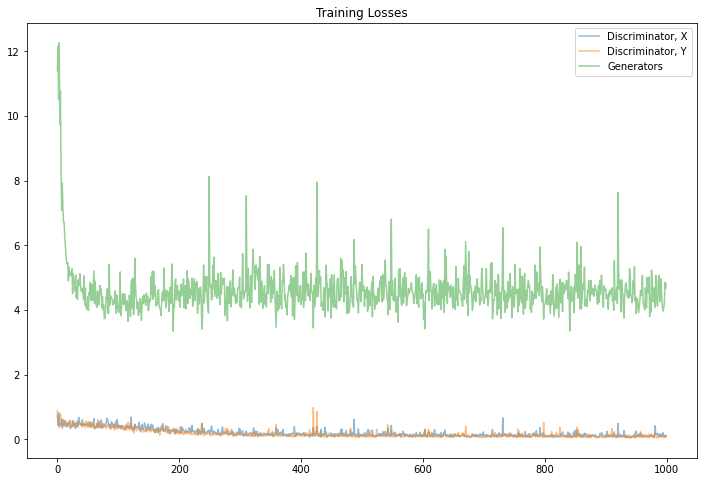

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')

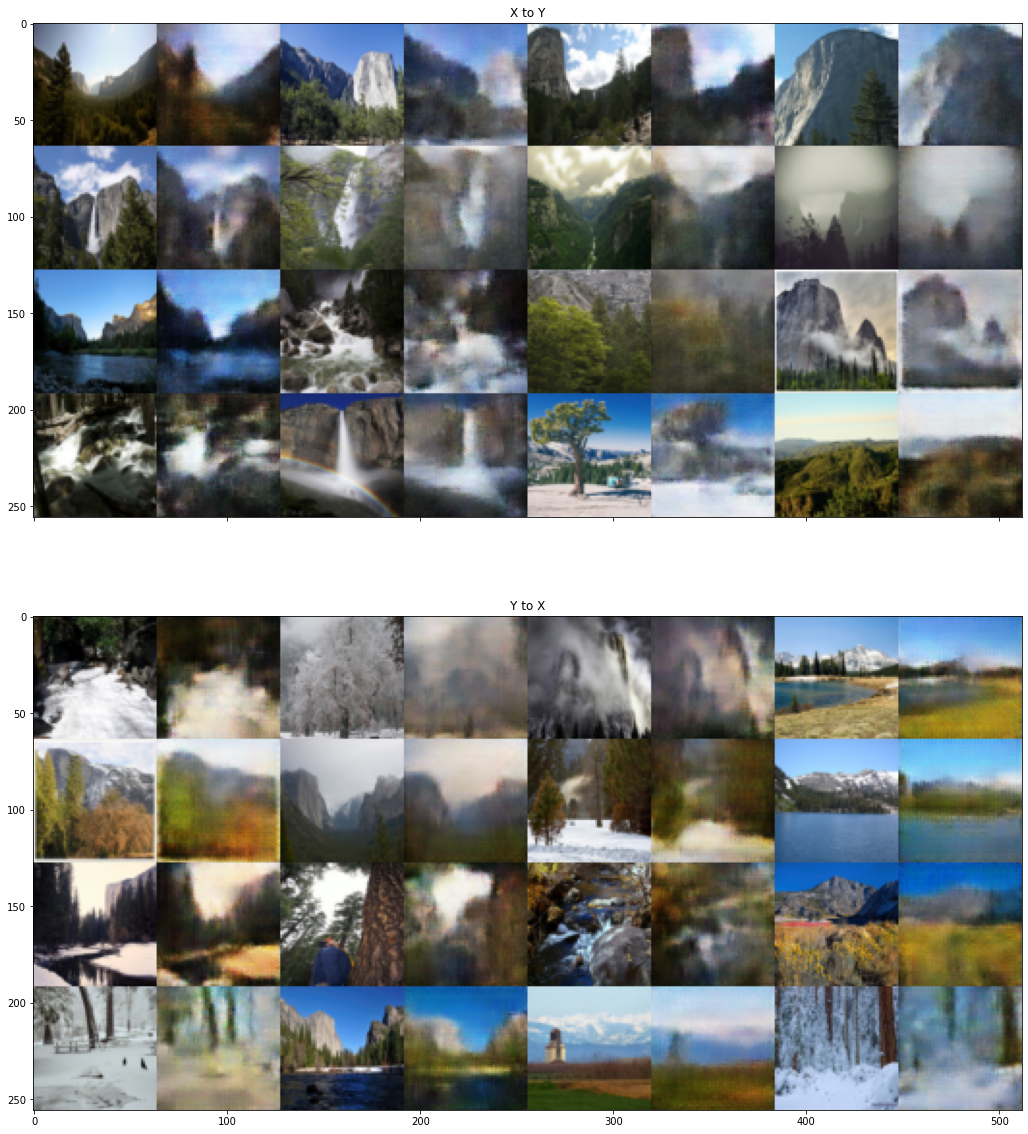

In [ ]:
view_samples(7000, '/content/drive/MyDrive/Classroom/CycleGAN/samples_cyclegan')

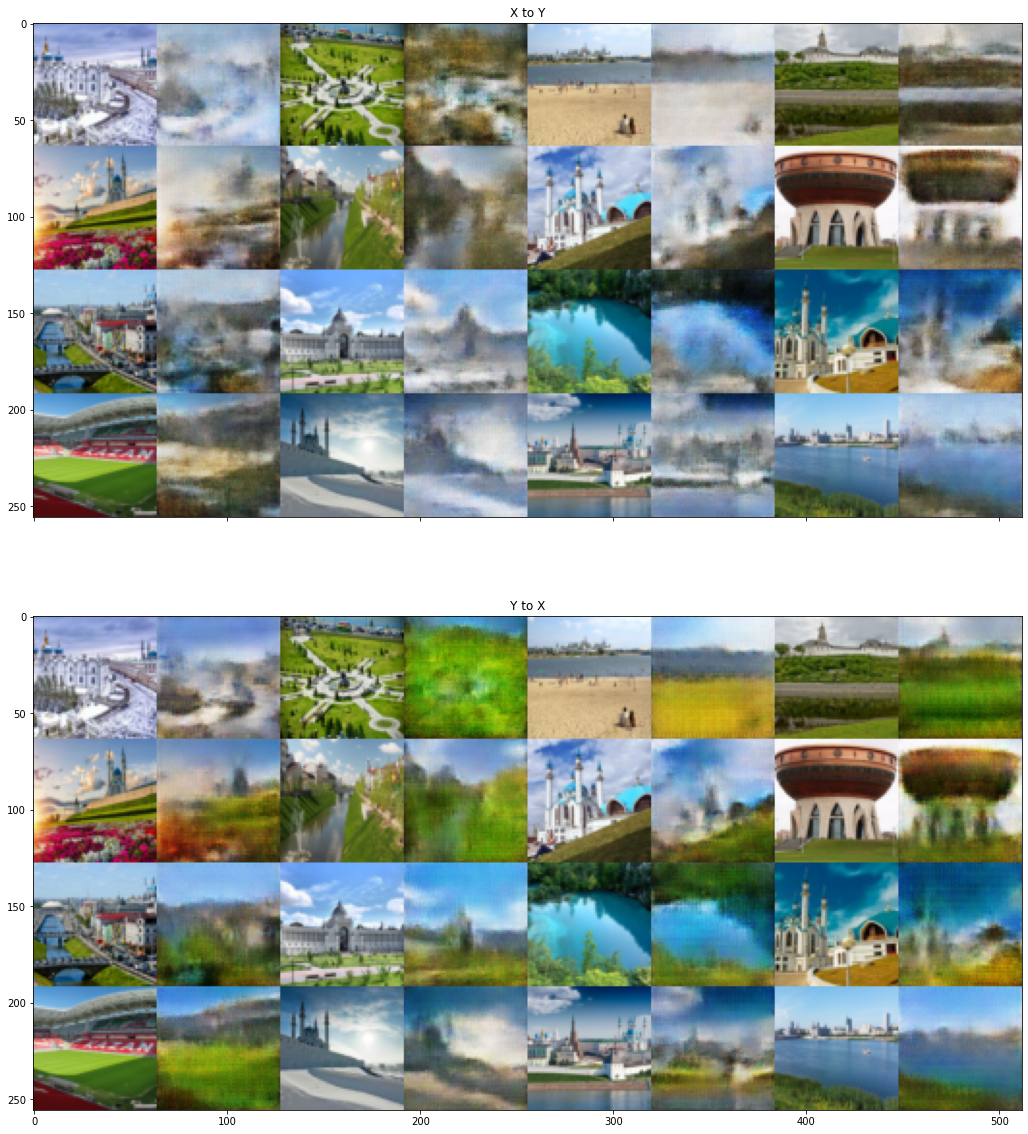

In [ ]:
view_samples(6000, '/content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan')

##Используемые статьи и работы:
* [Overview of CycleGAN architecture and training](https://towardsdatascience.com/overview-of-cyclegan-architecture-and-training-afee31612a2f)
* [Image-to-Image Translation using CycleGAN Model](https://towardsdatascience.com/image-to-image-translation-using-cyclegan-model-d58cfff04755)
* [CycleGAN Summer->Winter Image Translation PyTorch](https://www.kaggle.com/balraj98/cyclegan-summer-winter-image-translation-pytorch)
* [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf)
* [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/convolutional-networks/#conv)
* [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
* [Residual blocks — Building blocks of ResNet](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec)
* [](https://machinelearningmastery.com/cyclegan-tutorial-with-keras/)